<a href="https://colab.research.google.com/github/me-t1me/Bilateral_relation_paper/blob/master/Bilateral_relation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_white
import pandas_datareader as pdr
import datetime
import re

In [2]:
# to use data with sentiment of year before funding
lagging = True
# to remove data of indian investors
remove_indian_investors = True

# Data cleaning and processing
returns data: cleaned and processed pandas dataframe


In [3]:

if lagging:
  df = pd.read_excel("https://github.com/me-t1me/Bilateral_relation_paper/blob/master/Data_relations_with_lagging_sentiment.xlsx?raw=true")
else:
  df = pd.read_excel("https://github.com/me-t1me/Bilateral_relation_paper/blob/master/Data_relation.xlsx?raw=true")

In [4]:
if remove_indian_investors:
  df = df[df['Sentiment'] != 1]

In [5]:
df.head()

,Company,Company Type,Industry,Sector,Amount(US$M),Amount(INR Cr),Round,Stage,Investors,Investor Type,...,Valuation,Revenue (INR Cr),EBITDA (INR Cr),PAT (INR Cr),Total Debt (INR Cr),Cash & Cash Equ. (INR Cr),Book Value Per Share,Price Per Share,Link for Financials,Sentiment
6262,Arya Collateral,Unlisted,Agri-business,Agri Logistics,21.00,NaN,NaN,Late,"Quona Capital, LGT Lightstone Aspada, Omnivore...",Co-Investment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.159755
6263,Azooka Life Sciences,Unlisted,Healthcare & Life Sciences,Biotech,NaN,NaN,Seed,Early,Honeywell Ventures,Foreign,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.159755
6264,boAt,Unlisted,IT & ITES,IT Products (Hardware - Consumer Electronics),100.00,731.0,2,Early,Warburg Pincus,India-dedicated,...,Valuation Multiples are based on FY19 Financials.,240.74,14.45,8.73,14.49,0.02,NaN,283749,NaN,0.159755
6265,Chenani Nashri Tunnelway,Unlisted,Engg. & Construction,Infrastructure (Roads),527.96,3900.0,NaN,Buyout-Large,"I Squared Capital, IFC",Foreign,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.159755
6266,CoinDCX,Unlisted,IT & ITES,Online Services (Payments - Cryptocurrency),13.90,100.0,2,Early,"Polychain Capital, Coinbase Ventures, Others",Co-Investment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.159755


In [6]:
needed_col = ['Industry', 'Amount(US$M)', 'Stage', 'Investor Type', 'Date', 'Year Founded', 'State', 'Post Money Valuation (INR Cr)', 'Sentiment', 'Region']

In [7]:
regdata = df.loc[:, needed_col]

In [8]:
regdata = regdata.dropna()

In [9]:
len(regdata)

4140

In [10]:
regdata = regdata[regdata['Amount(US$M)'] != 0] 
regdata['funding'] = np.log(regdata['Amount(US$M)'])

In [11]:
regdata['Year'] = pd.to_datetime(regdata['Date'], format='%b-%y').dt.year

In [12]:
def remove_bad(x):
  try:
    return int(x)
  except:
    return 0

In [13]:
regdata['Year Founded'] = regdata['Year Founded'].apply(remove_bad)

In [14]:
regdata['Year Founded'].unique()

array([2013, 2018, 2011, 2007, 2019, 1984, 2016, 2015, 2006, 2020, 2012,
       2017, 1999, 2014, 2008, 2010, 1993, 2002, 2009, 1992, 1972, 1987,
       2004, 1990, 2000, 1971, 1994, 2001, 1996, 1995, 1982, 1988, 1989,
       1985, 1998, 1980, 1986, 2003, 1969, 2005, 1997, 1983, 1916, 1930,
       1929, 1991, 1979, 1970, 1981, 1978, 1951, 1945, 1973, 1947, 1943,
       1920, 1963, 1955, 1976, 1935,    0, 1961, 1952, 1875, 1974, 1917,
       1966, 1975, 1977, 1960, 1967, 1924, 1938, 1826, 1939, 1937, 1959,
       1962, 1944, 1964, 1884, 1905, 1881, 1019, 1946, 1957])

In [15]:
regdata['age'] = regdata['Year'].astype(np.int32) - regdata['Year Founded'].astype(np.int32) + 1

In [16]:
regdata = regdata[regdata['age'] > 0]

In [17]:
start_date = datetime.datetime(2004, 1, 1)
end_date = datetime.datetime(2020, 12, 31)
exchange_rates = pdr.DataReader('DEXINUS', 'fred', start_date, end_date)
exchange_rates

,DEXINUS
DATE,
2004-01-01,NaN
2004-01-02,45.68
2004-01-05,45.60
2004-01-06,45.66
2004-01-07,45.53
...,...
2020-12-25,NaN
2020-12-28,73.50
2020-12-29,73.33


In [18]:
exchange_rates = exchange_rates.dropna()

In [19]:
exchange_rates.index = exchange_rates.index.strftime('%b-%y')

In [20]:
exchange_rates = exchange_rates[~exchange_rates.index.duplicated(keep='first')]

In [21]:
regdata['exchange_rates'] = None

In [22]:
for i in regdata.index:
  regdata['exchange_rates'][i] = exchange_rates['DEXINUS'][regdata['Date'][i]]

<ipython-input-22-842fbc435bac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regdata['exchange_rates'][i] = exchange_rates['DEXINUS'][regdata['Date'][i]]


In [23]:
def clean_currency(x):
    if isinstance(x, str):
        return(x.replace(',', ''))
    return(x)

In [24]:
regdata['Post Money Valuation (INR Cr)'] = regdata['Post Money Valuation (INR Cr)'].apply(clean_currency).astype('float')

In [25]:
regdata['valuation'] = np.log(((regdata['Post Money Valuation (INR Cr)'] * 10 ) / regdata['exchange_rates']).astype(float))

In [26]:
def get_stage_dummy(x):
  if x == "Early":
    return 1
  
  return 0

In [27]:
def get_growth_dummy(x):
  if x == 'Growth-PE' or x == 'Growth':
    return 1
  else:
    return 0

In [28]:
regdata['Early'] = regdata['Stage'].apply(get_stage_dummy)

In [29]:
regdata["growth"] = regdata['Stage'].apply(get_growth_dummy)

In [30]:
regdata.head()

,Industry,Amount(US$M),Stage,Investor Type,Date,Year Founded,State,Post Money Valuation (INR Cr),Sentiment,Region,funding,Year,age,exchange_rates,valuation,Early,growth
6264,IT & ITES,100.0,Early,India-dedicated,Dec-20,2013,Maharashtra,2090.31,0.159755,West,4.605170,2020,8,73.51,5.650231,1,0
6267,IT & ITES,81.0,Growth-PE,Co-Investment,Dec-20,2018,Maharashtra,5878.80,0.159755,West,4.394449,2020,3,73.51,6.684272,0,1
6268,Education,40.0,Growth-PE,Co-Investment,Dec-20,2011,Karnataka,1263.19,0.159755,South,3.688879,2020,10,73.51,5.146559,0,1
6269,IT & ITES,100.0,Late,Co-Investment,Dec-20,2007,Karnataka,7406.10,0.159755,South,4.605170,2020,14,73.51,6.915223,0,0
6272,IT & ITES,145.0,Growth-PE,Foreign,Dec-20,2019,Karnataka,7406.10,0.159755,South,4.976734,2020,2,73.51,6.915223,0,1


In [31]:
inflation = {	
     2012:	11.17, 
     2011:	6.49 , 
     2020:	3.69 ,
     2010:	9.47 , 
     2019:	9.63 ,
     2009:	14.97,
     2018:	5.24 ,	 	
     2008:	9.70 , 
     2017:	4.00 ,	 	
     2007:	5.51 , 
     2016:	2.23 ,	 	
     2006:	6.53 , 
     2015:	6.32 ,	 	
     2005:	5.57 , 
     2014:	5.86 ,	 	
     2004:	3.78 , 
     2013:	9.13 ,	
    } 

regdata["inflation"] = None
for i in regdata.index:
  regdata["inflation"][i] = np.log(inflation[regdata["Year"][i]]).astype(float)

regdata.head()

<ipython-input-31-27f69ffdc747>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regdata["inflation"][i] = np.log(inflation[regdata["Year"][i]]).astype(float)


,Industry,Amount(US$M),Stage,Investor Type,Date,Year Founded,State,Post Money Valuation (INR Cr),Sentiment,Region,funding,Year,age,exchange_rates,valuation,Early,growth,inflation
6264,IT & ITES,100.0,Early,India-dedicated,Dec-20,2013,Maharashtra,2090.31,0.159755,West,4.605170,2020,8,73.51,5.650231,1,0,1.305626
6267,IT & ITES,81.0,Growth-PE,Co-Investment,Dec-20,2018,Maharashtra,5878.80,0.159755,West,4.394449,2020,3,73.51,6.684272,0,1,1.305626
6268,Education,40.0,Growth-PE,Co-Investment,Dec-20,2011,Karnataka,1263.19,0.159755,South,3.688879,2020,10,73.51,5.146559,0,1,1.305626
6269,IT & ITES,100.0,Late,Co-Investment,Dec-20,2007,Karnataka,7406.10,0.159755,South,4.605170,2020,14,73.51,6.915223,0,0,1.305626
6272,IT & ITES,145.0,Growth-PE,Foreign,Dec-20,2019,Karnataka,7406.10,0.159755,South,4.976734,2020,2,73.51,6.915223,0,1,1.305626


In [32]:
def format_volume(x):
  try:
    x = x[:-1].replace(',','')
    return float(x)*1000
  except:
    return x*1000

def format_price(x):
  try:
    x = x.replace(',','')
    return float(x)
  except:
    return x

In [33]:
# # Define the start and end dates
# start_date = date(2004, 1, 1)
# end_date = date(2020, 12, 31)

nifty_data = pd.read_csv("https://raw.githubusercontent.com/me-t1me/Bilateral_relation_paper/master/Nifty%2050%20Historical%20Data.csv")
# # Calculate the market capitalization for each day
nifty_data['Vol.'] = nifty_data['Vol.'].apply(format_volume)
nifty_data['Price'] = nifty_data['Price'].apply(format_price)

nifty_data['Market Cap'] = nifty_data['Price'] * nifty_data['Vol.']

nifty_data.index = pd.to_datetime(nifty_data["Date"], format='%m/%d/%Y')

nifty_monthly = nifty_data.resample('M')['Market Cap'].sum()

nifty_monthly.index = nifty_monthly.index.strftime('%b-%y')

In [34]:
regdata['mkt_cap'] = None

for i in regdata.index:
  date = regdata['Date'][i]
  ex = exchange_rates['DEXINUS'][date]
  regdata['mkt_cap'][i] = np.log(nifty_monthly[date] / (ex *  1000000))

<ipython-input-34-97fa81d3b4ad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regdata['mkt_cap'][i] = np.log(nifty_monthly[date] / (ex *  1000000))


In [35]:
regdata = regdata[regdata['Investor Type'] != 'Unknown']

In [36]:
regdata['Region'].unique()

array(['West', 'South', 'North', 'East', 'Central', 'Unknown'],
      dtype=object)

In [37]:
def get_region_dummy(x):
  if x == "Unknown":
    return np.nan
  else:
    return x

In [38]:
regdata['Region'] = regdata['Region'].apply(get_region_dummy)

In [39]:
print(len(regdata))
regdata = regdata.dropna()
print(len(regdata))
regdata['Region'].unique()

4126
4062


array(['West', 'South', 'North', 'East', 'Central'], dtype=object)

In [40]:
def making_dataframe(time_period, region):
  Columns = set(['Amount(US$M)', 'Stage', 'Year Founded', 'Post Money Valuation (INR Cr)', 'Year', 'exchange_rates', 'Region', 'State', 'Date', 'Year'])
  Columns.remove(time_period)
  Columns.remove(region)
  data = pd.get_dummies(regdata, columns=['Investor Type', region, 'Industry', time_period], drop_first=True)
  data.drop(columns=list(Columns), inplace=True)
  data.reset_index(drop=True, inplace=True)
  return data

In [41]:
data = making_dataframe('State', 'Date')
data_2 = making_dataframe('Region', 'Year')

In [42]:
print("data")
for i in data.columns:
  print(i)

data
Sentiment
funding
age
valuation
Early
growth
inflation
mkt_cap
Investor Type_Foreign
Investor Type_India-dedicated
Date_Apr-05
Date_Apr-06
Date_Apr-07
Date_Apr-08
Date_Apr-09
Date_Apr-10
Date_Apr-11
Date_Apr-12
Date_Apr-13
Date_Apr-14
Date_Apr-15
Date_Apr-16
Date_Apr-17
Date_Apr-18
Date_Apr-19
Date_Apr-20
Date_Aug-04
Date_Aug-05
Date_Aug-06
Date_Aug-07
Date_Aug-08
Date_Aug-09
Date_Aug-10
Date_Aug-11
Date_Aug-12
Date_Aug-13
Date_Aug-14
Date_Aug-15
Date_Aug-16
Date_Aug-17
Date_Aug-18
Date_Aug-19
Date_Aug-20
Date_Dec-04
Date_Dec-05
Date_Dec-06
Date_Dec-07
Date_Dec-08
Date_Dec-09
Date_Dec-10
Date_Dec-11
Date_Dec-12
Date_Dec-13
Date_Dec-14
Date_Dec-15
Date_Dec-16
Date_Dec-17
Date_Dec-18
Date_Dec-19
Date_Dec-20
Date_Feb-04
Date_Feb-05
Date_Feb-06
Date_Feb-07
Date_Feb-08
Date_Feb-09
Date_Feb-10
Date_Feb-11
Date_Feb-12
Date_Feb-13
Date_Feb-14
Date_Feb-15
Date_Feb-16
Date_Feb-17
Date_Feb-18
Date_Feb-19
Date_Feb-20
Date_Jan-04
Date_Jan-05
Date_Jan-06
Date_Jan-07
Date_Jan-08
Date_Jan-09
Date

In [43]:
print("data_2")
for i in data_2.columns:
  print(i)

data_2
Sentiment
funding
age
valuation
Early
growth
inflation
mkt_cap
Investor Type_Foreign
Investor Type_India-dedicated
Year_2005
Year_2006
Year_2007
Year_2008
Year_2009
Year_2010
Year_2011
Year_2012
Year_2013
Year_2014
Year_2015
Year_2016
Year_2017
Year_2018
Year_2019
Year_2020
Industry_Agri-business
Industry_BFSI
Industry_Diversified
Industry_Education
Industry_Energy
Industry_Engg. & Construction
Industry_FMCG
Industry_Food & Beverages
Industry_Gems & Jewelry
Industry_Healthcare & Life Sciences
Industry_Hotels & Resorts
Industry_IT & ITES
Industry_Manufacturing
Industry_Media & Entertainment
Industry_Mining & Minerals
Industry_Other Services
Industry_Retail
Industry_Shipping & Logistics
Industry_Sports & Fitness
Industry_Telecom
Industry_Textiles & Garments
Industry_Travel & Transport
Region_East
Region_North
Region_South
Region_West


# Regression

In [44]:
data.head()

,Sentiment,funding,age,valuation,Early,growth,inflation,mkt_cap,Investor Type_Foreign,Investor Type_India-dedicated,...,State_Madhya Pradesh,State_Maharashtra,State_Odisha,State_Punjab,State_Rajasthan,State_Tamil Nadu,State_Telangana,State_Uttar Pradesh,State_Uttarakhand,State_West Bengal
0,0.159755,4.605170,8,5.650231,1,0,1.305626,7.704974,0,1,...,0,1,0,0,0,0,0,0,0,0
1,0.159755,4.394449,3,6.684272,0,1,1.305626,7.704974,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.159755,3.688879,10,5.146559,0,1,1.305626,7.704974,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.159755,4.605170,14,6.915223,0,0,1.305626,7.704974,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.159755,4.976734,2,6.915223,0,1,1.305626,7.704974,1,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
data.describe()

,Sentiment,funding,age,valuation,Early,growth,Investor Type_Foreign,Investor Type_India-dedicated,Date_Apr-05,Date_Apr-06,...,State_Madhya Pradesh,State_Maharashtra,State_Odisha,State_Punjab,State_Rajasthan,State_Tamil Nadu,State_Telangana,State_Uttar Pradesh,State_Uttarakhand,State_West Bengal
count,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,...,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000
mean,0.247783,2.170338,15.631709,4.013737,0.312900,0.318808,0.422206,0.227720,0.001723,0.002954,...,0.004431,0.261694,0.002216,0.002216,0.015756,0.071640,0.050714,0.026834,0.000492,0.017233
std,0.290751,1.807579,91.084588,1.888066,0.463731,0.466072,0.493972,0.419413,0.041482,0.054279,...,0.066429,0.439611,0.047024,0.047024,0.124545,0.257922,0.219440,0.161618,0.022187,0.130154
min,-0.999244,-3.912023,1.000000,-1.642857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.180586,0.971724,4.000000,2.681131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.238732,2.197225,7.000000,3.936733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.330445,3.301285,14.000000,5.283543,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.998675,9.197400,2019.000000,11.079346,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Correlation

In [46]:
data['Sentiment'].describe(), data['funding'].describe()

(count    4062.000000
 mean        0.247783
 std         0.290751
 min        -0.999244
 25%         0.180586
 50%         0.238732
 75%         0.330445
 max         0.998675
 Name: Sentiment, dtype: float64,
 count    4062.000000
 mean        2.170338
 std         1.807579
 min        -3.912023
 25%         0.971724
 50%         2.197225
 75%         3.301285
 max         9.197400
 Name: funding, dtype: float64)

In [47]:
corr_mat = data[['Sentiment', 'funding']].corr()
corr_mat

,Sentiment,funding
Sentiment,1.000000,-0.040661
funding,-0.040661,1.000000


<Axes: xlabel='Sentiment', ylabel='funding'>

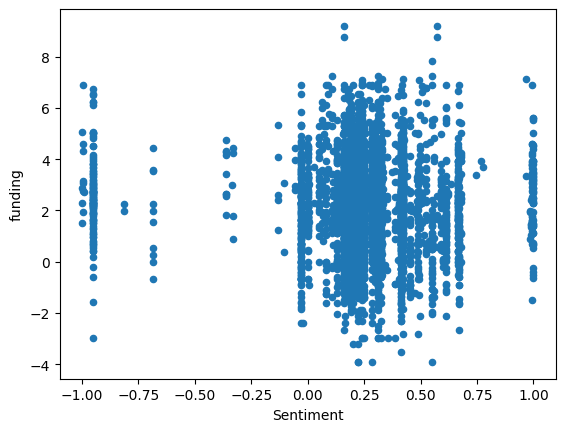

In [48]:
data.plot.scatter(x='Sentiment', y='funding')  # Create scatter plot

In [49]:
data1 = data[data['Sentiment'] != 1]

In [50]:
corr_mat1 = data1[['Sentiment', 'funding']].corr()
corr_mat1 

,Sentiment,funding
Sentiment,1.000000,-0.040661
funding,-0.040661,1.000000


<Axes: xlabel='Sentiment', ylabel='funding'>

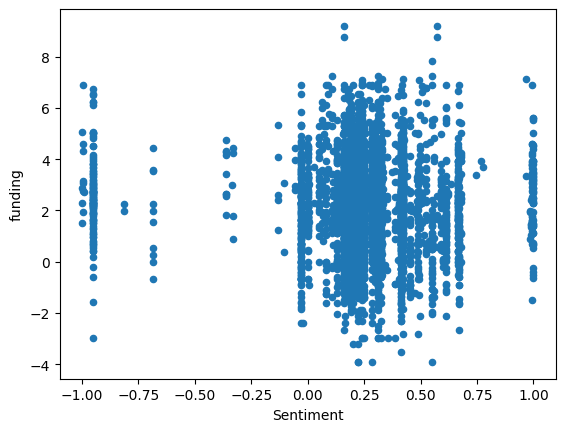

In [51]:
data1.plot.scatter(x='Sentiment', y='funding')

## First Table


### 1st column
X = Sentiment

Y = funding


In [52]:
X, Y = data['Sentiment'], data['funding']

In [53]:
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.724
Date:                Thu, 04 May 2023   Prob (F-statistic):            0.00955
Time:                        12:44:29   Log-Likelihood:                -8164.5
No. Observations:                4062   AIC:                         1.633e+04
Df Residuals:                    4060   BIC:                         1.635e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2330      0.037     59.963      0.0

### 2nd column
X = Sentiment, state, industry, time

Y = funding

In [54]:
X = data.drop(['funding', 'age', 'valuation','Early','inflation','mkt_cap','Investor Type_Foreign','Investor Type_India-dedicated', 'growth'], axis = 1)
Y = data["funding"]

In [55]:
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     2.890
Date:                Thu, 04 May 2023   Prob (F-statistic):           1.46e-41
Time:                        12:44:29   Log-Likelihood:                -7818.1
No. Observations:                4062   AIC:                         1.613e+04
Df Residuals:                    3813   BIC:                         1.771e+04
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

### 3rd column
X = Sentiment, state, industry, time, age, mkt_cap, inflation, early, valuation

Y = funding

In [56]:
X = data.drop(['funding', 'growth'], axis=1)
Y = data["funding"]

In [57]:
X = sm.add_constant(X)
model = sm.OLS(Y, X.astype(float)).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     47.39
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        12:44:30   Log-Likelihood:                -5278.4
No. Observations:                4062   AIC:                         1.106e+04
Df Residuals:                    3808   BIC:                         1.267e+04
Df Model:                         253                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

# Regression 2 (after midsem)

In [58]:
data_2.head()

,Sentiment,funding,age,valuation,Early,growth,inflation,mkt_cap,Investor Type_Foreign,Investor Type_India-dedicated,...,Industry_Retail,Industry_Shipping & Logistics,Industry_Sports & Fitness,Industry_Telecom,Industry_Textiles & Garments,Industry_Travel & Transport,Region_East,Region_North,Region_South,Region_West
0,0.159755,4.605170,8,5.650231,1,0,1.305626,7.704974,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0.159755,4.394449,3,6.684272,0,1,1.305626,7.704974,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.159755,3.688879,10,5.146559,0,1,1.305626,7.704974,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.159755,4.605170,14,6.915223,0,0,1.305626,7.704974,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.159755,4.976734,2,6.915223,0,1,1.305626,7.704974,1,0,...,0,0,0,0,0,0,0,0,1,0


In [59]:
data_2.describe()

,Sentiment,funding,age,valuation,Early,growth,Investor Type_Foreign,Investor Type_India-dedicated,Year_2005,Year_2006,...,Industry_Retail,Industry_Shipping & Logistics,Industry_Sports & Fitness,Industry_Telecom,Industry_Textiles & Garments,Industry_Travel & Transport,Region_East,Region_North,Region_South,Region_West
count,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,...,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000
mean,0.247783,2.170338,15.631709,4.013737,0.312900,0.318808,0.422206,0.227720,0.016987,0.029050,...,0.011817,0.023141,0.000246,0.008616,0.010094,0.012063,0.021664,0.272280,0.420975,0.278188
std,0.290751,1.807579,91.084588,1.888066,0.463731,0.466072,0.493972,0.419413,0.129237,0.167967,...,0.108074,0.150371,0.015690,0.092435,0.099971,0.109181,0.145602,0.445188,0.493776,0.448162
min,-0.999244,-3.912023,1.000000,-1.642857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.180586,0.971724,4.000000,2.681131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.238732,2.197225,7.000000,3.936733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.330445,3.301285,14.000000,5.283543,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,0.998675,9.197400,2019.000000,11.079346,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Part 1
X = Sentiment, state, industry, Year, age, mkt_cap, inflation, early, valuation

Y = funding

In [60]:
X = data_2.drop("funding", axis=1)
Y = data_2["funding"]
X = sm.add_constant(X)
model = sm.OLS(Y, X.astype(float)).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     229.7
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        12:44:30   Log-Likelihood:                -5422.9
No. Observations:                4062   AIC:                         1.095e+04
Df Residuals:                    4011   BIC:                         1.127e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

## Part 2
X = Sentiment * Early, Sentiment * Growth, Sentiment, state, industry, Year, age, mkt_cap, inflation, early, valuation

Y = Funding 

In [61]:
# making column for Sentiment*Early
data2_part1 = data_2.copy()
data2_part1['Sentiment*Early'] = data2_part1['Sentiment']*data2_part1['Early']
data2_part1["Sentiment*growth"] = data2_part1["Sentiment"]*data2_part1["growth"]
X = data2_part1.drop(['funding'], axis=1)
Y = data2_part1['funding']
X = sm.add_constant(X)
model = sm.OLS(Y, X.astype(float)).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     220.9
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        12:44:30   Log-Likelihood:                -5421.9
No. Observations:                4062   AIC:                         1.095e+04
Df Residuals:                    4009   BIC:                         1.128e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

## Part 3
X = Sentiment * Regions, Sentiment, state, industry, Year, age, mkt_cap, inflation, early, valuation

Y = funding

In [62]:
data2_part2 = data_2.copy()
for i in df['Region'].unique():
  try:
    data2_part2['Sentiment*'+i] = data2_part2["Sentiment"]*data2_part2["Region_"+i]
  except:
    pass

X = data2_part2.drop(['funding'], axis=1)
Y = data2_part2['funding']
X = sm.add_constant(X)
model = sm.OLS(Y, X.astype(float)).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     212.6
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        12:44:30   Log-Likelihood:                -5422.0
No. Observations:                4062   AIC:                         1.095e+04
Df Residuals:                    4007   BIC:                         1.130e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

## Part 4
X = Sentiment * Industry, Sentiment, state, industry, Year, age, mkt_cap, inflation, early, valuation

Y = funding

In [63]:
# making column for Sentiment*Early
data2_part3 = data_2.copy()
for i in df['Industry'].unique():
  try:
    data2_part3['Sentiment*'+i] = data2_part3["Sentiment"]*data2_part3["Industry_"+i]
  except:
    pass

X = data2_part3.drop(['funding'], axis=1)
Y = data2_part3['funding']
X = sm.add_constant(X)
model = sm.OLS(Y, X.astype(float)).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     164.3
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        12:44:31   Log-Likelihood:                -5413.6
No. Observations:                4062   AIC:                         1.097e+04
Df Residuals:                    3991   BIC:                         1.142e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
